In [1]:
'''
Generate the dect projection data set. 3 layer mean
'''

'\nGenerate the dect projection data set. 3 layer mean\n'

In [2]:
import pandas as pd
import SimpleITK as sitk
import h5py
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

In [3]:
def pad_projection_b(prj_a, prj_b, n_pixels = 20, reg = 0.1):
    margin = int((prj_a.shape[2] - prj_b.shape[2]) / 2)
    
    prj_b_left = prj_b[..., :n_pixels]
    prj_a_left = prj_a[..., margin:margin+n_pixels]
    coefs_left = np.sum(prj_b_left * prj_a_left, 2) / np.sum(prj_b_left * prj_a_left + reg, 2)
    
    prj_b_right = prj_b[..., -n_pixels:]
    prj_a_right = prj_a[..., -margin-n_pixels:-margin]
    coefs_right = np.sum(prj_b_right * prj_a_right, 2) / np.sum(prj_b_right * prj_a_right + reg, 2)
    
    extrap_prj_b = np.zeros_like(prj_a)
    extrap_prj_b[..., :margin] = prj_a[..., :margin] * coefs_left[..., np.newaxis]
    extrap_prj_b[..., margin:-margin] = prj_b
    extrap_prj_b[..., -margin:] = prj_a[..., -margin:] * coefs_right[..., np.newaxis]
    
    return extrap_prj_b

In [4]:
# list input files
input_dir = '/home/dwu/data/DECT/sinogram/'
nlayers = 3
nslices = 100

full_dose_files = glob.glob(os.path.join(input_dir, 'sino_*_1.mat'))
full_dose_files = pd.DataFrame([{'id': int(os.path.basename(f).split('_')[1]), 'prj_full': f} for f in full_dose_files])

half_dose_files = glob.glob(os.path.join(input_dir, 'sino_*_2.mat'))
half_dose_files = pd.DataFrame([{'id': int(os.path.basename(f).split('_')[1]), 'prj_half': f} for f in half_dose_files])

input_files = pd.merge(full_dose_files, half_dose_files, on = 'id')
input_files = input_files.sort_values('id', ignore_index=True)

for i, row in input_files.iterrows():
    print (i, row)

0 id                                                  2
prj_full    /home/dwu/data/DECT/sinogram/sino_2_1.mat
prj_half    /home/dwu/data/DECT/sinogram/sino_2_2.mat
Name: 0, dtype: object
1 id                                                  3
prj_full    /home/dwu/data/DECT/sinogram/sino_3_1.mat
prj_half    /home/dwu/data/DECT/sinogram/sino_3_2.mat
Name: 1, dtype: object
2 id                                                  4
prj_full    /home/dwu/data/DECT/sinogram/sino_4_1.mat
prj_half    /home/dwu/data/DECT/sinogram/sino_4_2.mat
Name: 2, dtype: object
3 id                                                  5
prj_full    /home/dwu/data/DECT/sinogram/sino_5_1.mat
prj_half    /home/dwu/data/DECT/sinogram/sino_5_2.mat
Name: 3, dtype: object
4 id                                                  6
prj_full    /home/dwu/data/DECT/sinogram/sino_6_1.mat
prj_half    /home/dwu/data/DECT/sinogram/sino_6_2.mat
Name: 4, dtype: object
5 id                                                  7
prj_full 

In [8]:
output_dir = '/home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
input_manifest = input_files[input_files.id.isin([58,59,60])].reset_index(drop = True)

input_manifest

,id,prj_full,prj_half
0,58,/home/dwu/data/DECT/sinogram/sino_58_1.mat,/home/dwu/data/DECT/sinogram/sino_58_2.mat
1,59,/home/dwu/data/DECT/sinogram/sino_59_1.mat,/home/dwu/data/DECT/sinogram/sino_59_2.mat
2,60,/home/dwu/data/DECT/sinogram/sino_60_1.mat,/home/dwu/data/DECT/sinogram/sino_60_2.mat


3
0 58


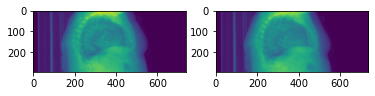

1 59


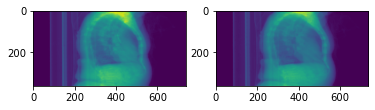

2 60


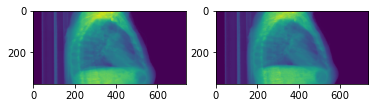

In [9]:
np.random.seed(0)
print (len(input_manifest))
manifest = []

for i, row in input_manifest.iterrows():
    print (i, row.id, flush=True)

    with h5py.File(row.prj_full, 'r') as f:
        prj_full_a = np.copy(f['sinoA']).astype(np.float32)
        prj_full_b = np.copy(f['sinoB']).astype(np.float32)
    prj_full_b = pad_projection_b(prj_full_a, prj_full_b)
    
    with h5py.File(row.prj_half, 'r') as f:
        prj_half_a = np.copy(f['sinoA']).astype(np.float32)
        prj_half_b = np.copy(f['sinoB']).astype(np.float32)
    prj_half_b = pad_projection_b(prj_half_a, prj_half_b)

    plt.figure()
    plt.subplot(121); plt.imshow(prj_full_a[:, 0, :])
    plt.subplot(122); plt.imshow(prj_half_a[:, 0, :])
    plt.show()

    # select the layers    
    inds = np.arange(0, min(len(prj_full_a), len(prj_full_b)) + 1 - nlayers)
    inds = np.random.choice(inds, nslices, False)
    inds = np.sort(inds)
    
    manifest += [{'Tag': 'sino_%d'%row.id, 'Slice': i} for i in inds]

    # calculate 3-layer mean
    for name in ['prj_full', 'prj_half']:
        if name == 'prj_full':
            prj_a = prj_full_a
            prj_b = prj_full_b
        else:
            prj_a = prj_half_a
            prj_b = prj_half_b
        
        selected_a = []
        selected_b = []
        for i in inds:
            selected_a.append(prj_a[i:i+nlayers].mean(0))
            selected_b.append(prj_b[i:i+nlayers].mean(0))
        selected_a = np.array(selected_a).astype(np.float32)
        selected_b = np.array(selected_b).astype(np.float32)

        sitk_a = sitk.GetImageFromArray(selected_a)
        sitk_b = sitk.GetImageFromArray(selected_b)
        
        current_dir = os.path.join(output_dir, name)
        if not os.path.exists(current_dir):
            os.makedirs(current_dir)

        sitk.WriteImage(sitk_a, os.path.join(current_dir, 'sino_%d_a.nii'%row.id))
        sitk.WriteImage(sitk_b, os.path.join(current_dir, 'sino_%d_b.nii'%row.id))

manifest = pd.DataFrame(manifest)
manifest.to_csv(os.path.join(output_dir, 'manifest.csv'), index=False)